# Import relevant modules and data

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score

In [2]:
# Load personal loan data into a Pandas DataFrame from the given file
df_loan_data = pd.read_excel('personal-loan.xls', index_col = 0, header = 1)

# Apply relevant transformations from exploratory analysis

In [3]:
# Remove all rows containing any NaN values
df_loan_data.dropna(how = 'any', inplace = True)

In [4]:
# Cast columns that should be integers as such
for col in df_loan_data.columns:
    if is_float_dtype(df_loan_data[col]) == True:
        if col != 'credit_card_spend':
            df_loan_data[col] = df_loan_data[col].astype(int)

In [5]:
# Enforce reccomended variable caps
df_loan_data['age'] = df_loan_data['age'].apply(lambda x: min(x, 66))
df_loan_data['yrs_experience'] = df_loan_data['yrs_experience'].apply(lambda x: min(x, 42))
df_loan_data['family_size'] = df_loan_data['family_size'].apply(lambda x: min(x, 4))

In [6]:
# Create reccomended new columns
df_loan_data['has_mortgage'] = df_loan_data['mortgage_amt'].apply(lambda x: 0 if x == 0 else 1)
df_loan_data['has_credit_spend'] = df_loan_data['credit_card_spend'].apply(lambda x: 0 if x == 0 else 1)

In [7]:
# Impute values as reccomended for mortgage_amt
zero_mortgage_indices = df_loan_data['mortgage_amt'] == 0
non_zero_mortgage_values = df_loan_data.loc[~zero_mortgage_indices, 'mortgage_amt']
random_mortgage_sample = np.random.choice(non_zero_mortgage_values, zero_mortgage_indices.sum())
df_loan_data.loc[zero_mortgage_indices, 'mortgage_amt'] = random_mortgage_sample

In [8]:
# Impute values as reccomended for credit_card_spend
zero_cspend_indices = df_loan_data['credit_card_spend'] == 0
non_zero_cspend_values = df_loan_data.loc[~zero_cspend_indices, 'credit_card_spend']
random_cspend_sample = np.random.choice(non_zero_cspend_values, zero_cspend_indices.sum())
df_loan_data.loc[zero_cspend_indices, 'credit_card_spend'] = random_cspend_sample

In [9]:
# Re-cast two-value columns such that 'yes' = 1, and 'no' = 0
two_val_cols = ['personal_loan', 'online_acct', 'credit_card_acct']
replace_dict = {'yes' : 1, 'no' : 0}
df_loan_data.loc[:, two_val_cols] = df_loan_data.loc[:, two_val_cols].replace(replace_dict)

In [10]:
# Re-cast education_level as a numeric column s.t. increasing value = increasing education
replace_dict = {'Undergraduate' : 0, 'Graduate' : 1, 'Advanced or Professional' : 2}
df_loan_data.loc[:, 'education_level'] = df_loan_data.loc[:, 'education_level'].replace(replace_dict)

In [11]:
# Set DataFrame dtypes to match new column types
new_types = {
    'education_level': int,
    'credit_card_acct': int,
    'online_acct': int,
    'personal_loan': int
}
df_loan_data = df_loan_data.astype(new_types)

# Normalize and scale all features as appropriate

Regularization:
Some models (e.g., linear regression) may benefit from regularization techniques like L1 or L2 regularization, which automatically handle feature selection and scaling.

Feature Selection:
Consider feature selection techniques to identify the most relevant features for your model. Techniques like Recursive Feature Elimination (RFE) or feature importance from tree-based models can be helpful.

Model Evaluation:
Continuously monitor and evaluate your model's performance to understand the impact of transformations. Cross-validation and performance metrics (e.g., ROC-AUC, RMSE, etc.) can guide your choices.

In [12]:
# Keep a copy of un-scaled data for use in new feature generation later
df_loan_data_prescale = df_loan_data.copy()

In [13]:
# MinMax scale non-continuous ordinal variables
ordinal_feats = ['age', 'yrs_experience', 'family_size', 'education_level']
scaler = MinMaxScaler()
df_loan_data[ordinal_feats] = scaler.fit_transform(df_loan_data[ordinal_feats])

In [14]:
# Apply Box-Cox transformations to help remove skew from continuous variables
# This transformation was chosen because it removed skew better than log/sqrt transforms for all listed features
cont_feats = ['income', 'mortgage_amt', 'credit_card_spend']
for feat in cont_feats:
    transformed_column, _ = boxcox(df_loan_data[feat])
    df_loan_data[feat] = transformed_column

# Layer MinMax scaling so all features have similar range
scaler = MinMaxScaler()
df_loan_data[cont_feats] = scaler.fit_transform(df_loan_data[cont_feats])

# Create and scale relevant new features  
Will generally only keep these if more correlated with target than original features

In [15]:
# Create debt_to_income_ratio as (mortgage_amt + credit_card_spend) / income
df_loan_data['debt_to_income_ratio'] = np.round((
    df_loan_data_prescale['mortgage_amt'] 
    + df_loan_data_prescale['credit_card_spend']
    ) / df_loan_data_prescale['income'],
    2)

In [16]:
# Create num_accts as indicator of total number of accounts held
df_loan_data['num_accts'] = (
    df_loan_data['share_trading_acct'] 
    + df_loan_data['fixed_deposit_acct']
    + df_loan_data['credit_card_acct']
    + df_loan_data['online_acct']
)

In [17]:
# Create credit spend to income ratio as credit_card_spend / income
df_loan_data['cspend_to_income'] = df_loan_data['credit_card_spend'] / df_loan_data_prescale['income']

In [18]:
# Create fin_exposure as sum of normalized mortgage_amt + credit_card_spend
df_loan_data['fin_exposure'] = df_loan_data['mortgage_amt'] + df_loan_data['credit_card_spend']

In [19]:
# Create as financial maturity as age * income
df_loan_data['fin_maturity'] = df_loan_data['age'] * df_loan_data['income']

In [20]:
# Apply Box-Cox transformations to help remove skew from continuous variables
# This transformation was chosen because it removed skew better than log/sqrt transforms for all listed features
skewed_feats = ['debt_to_income_ratio', 'cspend_to_income', 'fin_maturity']
for feat in skewed_feats:
    
    shift = 0.01
    if feat == 'debt_to_income_ratio':
        shift = 1.24
        
    shifted_column = df_loan_data[feat] + shift
    transformed_column, _ = boxcox(shifted_column)
    df_loan_data[feat] = transformed_column

# Layer MinMax scaling so all features have similar range
scaler = MinMaxScaler()
new_feats = ['debt_to_income_ratio', 'num_accts', 'fin_exposure', 'cspend_to_income', 'fin_maturity']
df_loan_data[new_feats] = scaler.fit_transform(df_loan_data[new_feats])

In [21]:
# Visualize new numeric variables
#new_vars = ['debt_to_income_ratio', 'num_accts', 'fin_exposure', 'cspend_to_income', 'fin_maturity']
#for feat in new_vars:
#    plt.figure(figsize=(12, 4))
#    sns.histplot(data=df_loan_data, x=feat, kde=True)
#    plt.title('Histogram for {}'.format(feat))
#    plt.show()

# Explore which features to remove

## Correlation analysis

Explore the correlations between highly correlated (>0.6) features (and the target)

In [22]:
# Sepcify target variable
target_variable = 'personal_loan'

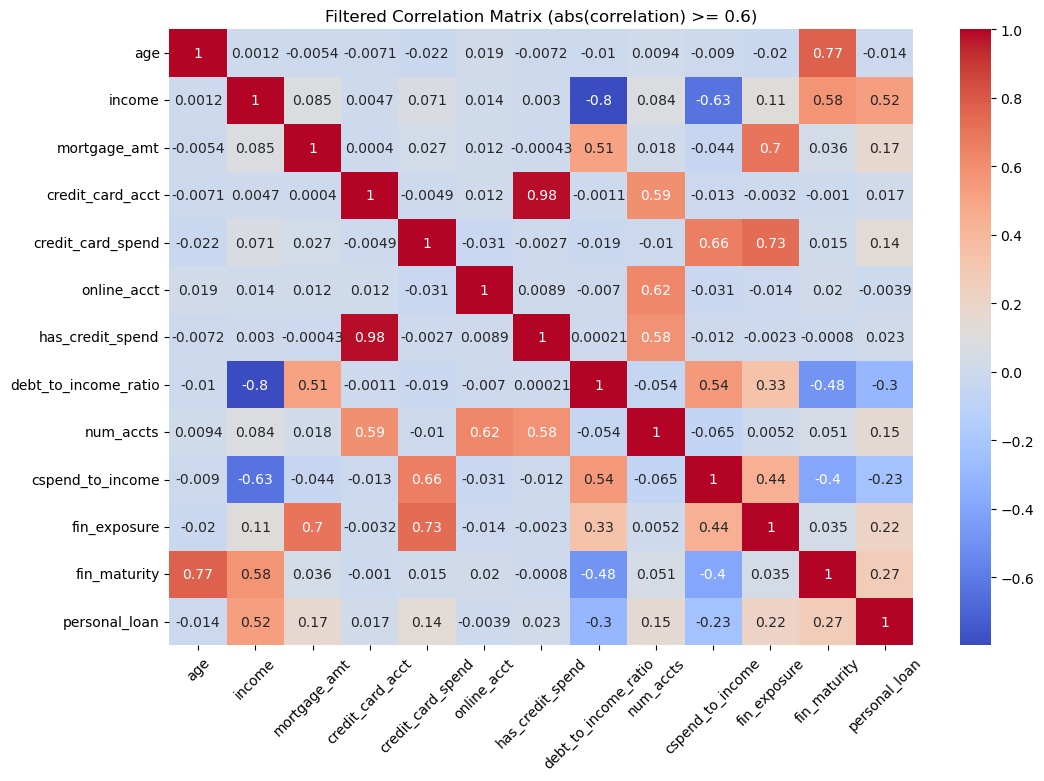

In [23]:
# Compute the correlation matrix
correlation_matrix = df_loan_data.corr()

# Set correlation threshold to filter by
corr_thresh = 0.6

# Find the rows and columns that meet the correlation condition
rows, cols = np.where((np.abs(correlation_matrix) >= corr_thresh) & (correlation_matrix < 1.0))

# Get unique rows and columns to display
unique_rows = np.unique(rows)
unique_cols = np.unique(cols)

# Ensure that the target variable is included in the filtered correlation matrix
if target_variable not in unique_cols:
    unique_cols = np.append(unique_cols, np.where(df_loan_data.columns == target_variable))
if target_variable not in unique_rows:
    unique_rows = np.append(unique_rows, np.where(df_loan_data.columns == target_variable))

# Create a filtered correlation matrix using label-based indexing (loc)
filtered_correlation_matrix = correlation_matrix.loc[df_loan_data.columns[unique_rows], df_loan_data.columns[unique_cols]]

# Display the filtered correlation matrix in a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Filtered Correlation Matrix (abs(correlation) >= {})'.format(corr_thresh))
plt.xticks(rotation=45)
plt.show()

In [24]:
# Based on the above matrix, remove one from each pair of features with correlation > threshold
# Keep feature with higher target correlation
corr_feats_to_drop = [
    'age',
    'credit_card_acct',
    'num_accts',
    'cspend_to_income',
    'credit_card_acct',
    'credit_card_spend',
    'online_acct',
    'debt_to_income_ratio',
    'mortgage_amt'
]
df_loan_data.drop(columns = corr_feats_to_drop, inplace=True)

## Logistic Regression RFE analysis

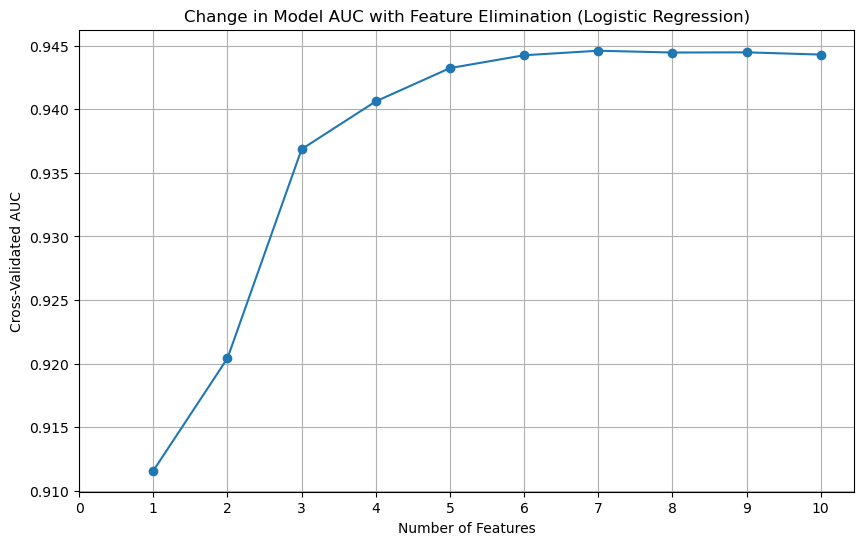

In [25]:
# Separate features and target variable
X = df_loan_data.drop(columns=[target_variable])
y = df_loan_data[target_variable]

# Initialize the model for RFE (e.g., Logistic Regression)
model = LogisticRegression()

# Initialize the RFE selector
rfe = RFE(model)

# Lists to store results
num_features_list = []
AUC_list = []

# Loop through the feature elimination process
for i in range(1, len(X.columns) + 1):
    rfe.n_features_to_select = i
    rfe.fit(X, y)
    
    # Get the selected features
    selected_features = X.columns[rfe.support_]
    
    # Evaluate model performance using cross-validation
    AUC = np.mean(cross_val_score(model, X[selected_features], y, cv=5, scoring='roc_auc'))

    # Store results
    num_features_list.append(i)
    AUC_list.append(AUC)

# Plot the change in accuracy as features are eliminated
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, AUC_list, marker='o')
plt.xticks(np.arange(df_loan_data.shape[1]))
plt.title('Change in Model AUC with Feature Elimination (Logistic Regression)')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated AUC')
plt.grid(True)
plt.show()

In [26]:
# Based on the Logistic RFE analysis. We should keep 6 features, and drop the following:
rfe.n_features_to_select = 6
rfe.fit(X, y)
    
# Get the selected features
selected_feats = X.columns[rfe.support_]
logistic_RFE_feats_to_drop = [col for col in df_loan_data.columns if col not in list(selected_feats) + [target_variable]]
print(logistic_RFE_feats_to_drop)

['yrs_experience', 'share_trading_acct', 'has_credit_spend', 'fin_maturity']


## LGBM trees RFE analysis

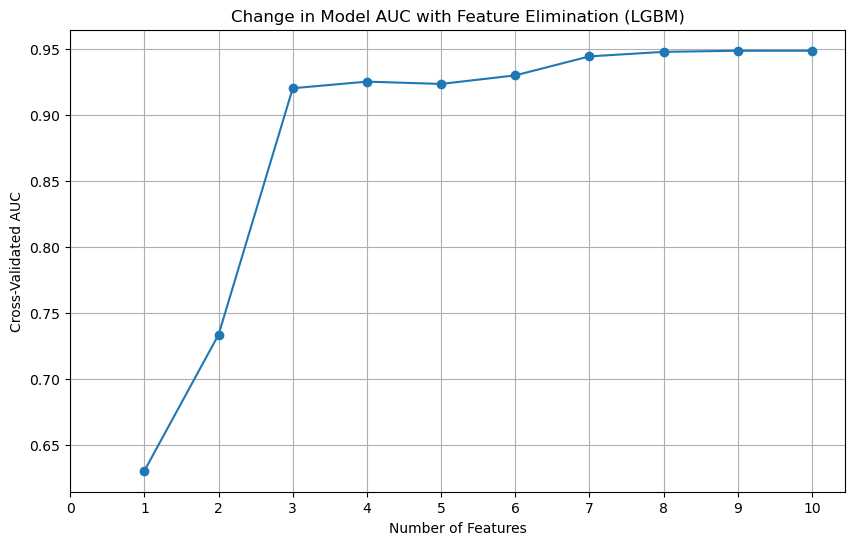

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier  # Import LGBMClassifier
from sklearn.model_selection import cross_val_score

# Define the target variable
target_variable = 'personal_loan'

# Separate features and target variable
X = df_loan_data.drop(columns=[target_variable])
y = df_loan_data[target_variable]

# Initialize the model for RFE (LGBMClassifier)
model = LGBMClassifier()

# Initialize the RFE selector
rfe = RFE(model)

# Lists to store results
num_features_list = []
AUC_list = []

# Loop through the feature elimination process
for i in range(1, len(X.columns) + 1):
    rfe.n_features_to_select = i
    rfe.fit(X, y)
    
    # Get the selected features
    selected_features = X.columns[rfe.support_]
    
    # Evaluate model performance using cross-validation
    AUC = np.mean(cross_val_score(model, X[selected_features], y, cv=5, scoring='roc_auc'))

    # Store results
    num_features_list.append(i)
    AUC_list.append(AUC)

# Plot the change in AUC as features are eliminated
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, AUC_list, marker='o')
plt.xticks(np.arange(df_loan_data.shape[1]))
plt.title('Change in Model AUC with Feature Elimination (LGBM)')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated AUC')
plt.grid(True)
plt.show()

In [28]:
# Based on the LGBM RFE analysis. We should keep 8 features, and drop the following:
rfe.n_features_to_select = 8
rfe.fit(X, y)
    
# Get the selected features
selected_feats = X.columns[rfe.support_]
LGBM_RFE_feats_to_drop = [col for col in df_loan_data.columns if col not in list(selected_feats) + [target_variable]]
print(LGBM_RFE_feats_to_drop)

['share_trading_acct', 'has_credit_spend']


## Remove commonly unhelpful features & export final dataset

Both RFE models judge the following features to be un-impactful: ['share_trading_acct', 'has_credit_spend']

In [29]:
# Remove & export
df_loan_data.drop(columns = ['share_trading_acct', 'has_credit_spend'], inplace=True)
df_loan_data.to_pickle('df_loan_data.pkl')